# Bad Electrode Detection

Start by importing dependencies. Will need scipy and numpy

In [216]:
from scipy import stats
import numpy as np
import sys
sys.path.append('../src/')
import utils.plots as plots

Define probability distribution wrapper function. For now simply implements KDE.

In [217]:
def get_probarr(elec):
    kernel = stats.gaussian_kde(elec)
    return np.reshape(kernel(elec).T, elec.shape)

Define the joint prob function to be used later

In [218]:
def get_jointprob(probarr):
    return -np.sum(np.multiply(probarr, np.log(probarr)))

## Simulated Data
Basically, this method will call out data that has more variation and thus is less likely to be true than others. So basically, I'm going to make some really closely bunched sine waves and then a huge noisy wave that is less likely a real signal.

### First generate simulated data

In [219]:
times = np.linspace(0, 1, 1000)
cos = np.cos(2 * np.pi * times)
# 5 cosine waves overlayed on each other
data = np.column_stack([cos] * 5)
data = np.expand_dims(data, 2)

In [220]:
# Generate white noise
T = 100
Fs = 10
mean = 0
std = 1 
wn = np.random.normal(mean, std, scale=2.0, size=T * Fs)
times = np.arange(len(wn)) / float(Fs)
data[:, 4, -1] = data[:, 4, -1] + wn.T

TypeError: normal() got multiple values for keyword argument 'scale'

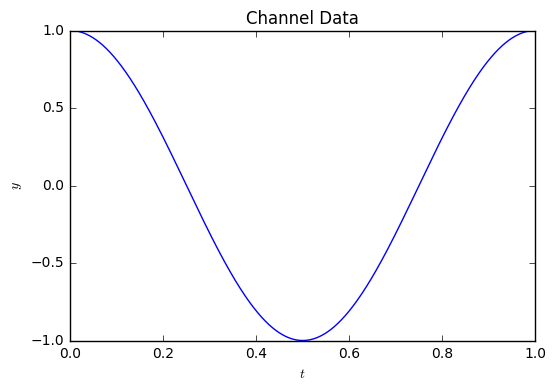

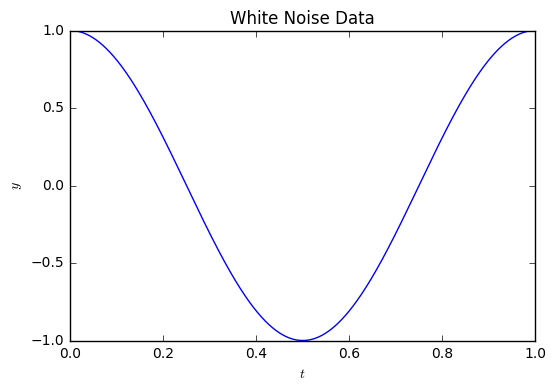

In [221]:
plots.plot_timeseries(data = data[:,0],
                      time = times,
                      selector = "all",
                      title = "Channel Data",
                      xlab = r'$t$',
                      ylab = r'$y$')
int_coord = list(rand_coord())[:-1]

plots.plot_timeseries(data = data[:,4],
                      time = times,
                      selector = "all",
                      title = "White Noise Data",
                      xlab = r'$t$',
                      ylab = r'$y$')
int_coord = list(rand_coord())[:-1]

#### Go step by step.
Start by reshaping data

In [222]:
print "Original dimensions:", data.shape

inEEG = data

electrodes = 0
trials = 0
times = 0

if len(inEEG.shape) == 3:
    electrodes = inEEG.shape[1]
    times = inEEG.shape[0]
    trials = inEEG.shape[2]
    inEEG = np.reshape(inEEG, (inEEG.shape[0], inEEG.shape[1] * inEEG.shape[2]))
elif len(inEEG.shape) != 1 or len(inEEG.shape) != 2:
    # fail case
    print "fail"
    
print "Final dimensions:", inEEG.shape

Original dimensions: (1000L, 5L, 1L)
Final dimensions: (1000L, 5L)


**As can seen above, matrix is reshaped into a 2 dimensional matrix or a 1 dimensional vector for later use.**

Next, sample running the probability distribution function.

In [223]:
regelec = inEEG[:, 0]
#print regelec
kernel1 = stats.gaussian_kde(regelec)
print min(regelec)
print max(regelec)
x1 = np.linspace(-1, 1, 1000)
probdist = np.reshape(kernel1(x1).T, regelec.shape)
print kernel1(0)
print kernel1(-1)
print kernel1(1)

-0.999995055317
1.0
[ 0.32343492]
[ 0.4691347]
[ 0.47137853]


In [224]:
regelec = inEEG[:, 1]
#print regelec
kernel1a = stats.gaussian_kde(regelec)
print min(regelec)
print max(regelec)
x1 = np.linspace(-1, 1, 1000)
probdist = np.reshape(kernel1a(x1).T, regelec.shape)
print kernel1a(0)
print kernel1a(-1)
print kernel1a(1)

-0.999995055317
1.0
[ 0.32343492]
[ 0.4691347]
[ 0.47137853]


In [225]:
badelec = inEEG[:, 4]
#print regelec
kernel2 = stats.gaussian_kde(badelec)
print min(badelec)
print max(badelec)
x2 = np.linspace(min(badelec), max(badelec), 1000)
badprobdist = np.reshape(kernel2(x2).T, regelec.shape)
print badprobdist.shape
print kernel2(0)
print kernel2(-1)
print kernel2(1)

-0.999995055317
1.0
(1000L,)
[ 0.32343492]
[ 0.4691347]
[ 0.47137853]


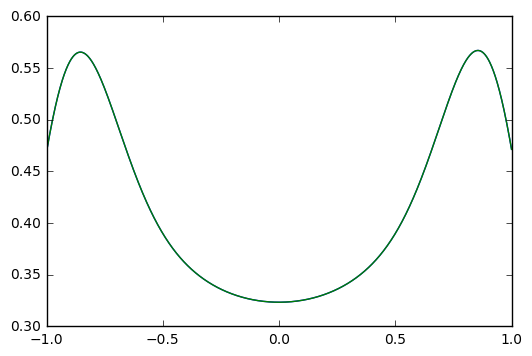

In [226]:
import matplotlib.pyplot as plt
plt.plot(x1, probdist)
plt.plot(x2, badprobdist)
plt.show()

In [227]:
print "Regular Plot:", kernel1.integrate_box_1d(-1, 1)
print "Regular Plot 2:", kernel1a.integrate_box_1d(-1, 1)
print "Bad Plot:", kernel2.integrate_box_1d(-1, 1)

Regular Plot: 0.841026809042
Regular Plot 2: 0.841026809042
Bad Plot: 0.841026809042


*Run 2 of the same plot to check replicability.* Now, we add in calculating joint probability

In [228]:
# Then, initialize a probability vector of electrode length
probvec = np.zeros(electrodes)
# iterate through electrodes and get joint probs
for i in range(0, electrodes):
    # get prob distribution
    probarr = get_probarr(inEEG[:, i])
    # using probdist find joint prob
    jp = get_jointprob(probarr)
    # put prob in array
    probvec[i] = jp
print probvec

[ 350.79863473  350.79863473  350.79863473  350.79863473  350.79863473]


In [229]:
# normalize probvec
# first calc mean
avg = np.mean(probvec)
# then std dev
stddev = np.std(probvec)
# then figure out which electrodes are bad
badelec = []
for i in range(0, len(probvec)):
    print i, ((avg - probvec[i]) / stddev)
    if ((avg - probvec[i]) / stddev) >= 3.0:
        badelec.append(i)
print avg
print stddev
print badelec

0 nan
1 nan
2 nan
3 nan
4 nan
350.798634728
0.0
[]


C:\Users\Nitin\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Nitin\Anaconda2\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: invalid value encountered in double_scalars


##### Note
that there was no rejection of any electrodes, even the bad one. That's because with the given data, it was only 2 standard deviations off instead of 3.

Now define bad electrode funciton.

**Input:** EEG data electrode x time x trial

**Output:** bad electrode indices

In [230]:
def prob_badelec(inEEG, threshold):
    electrodes = 0
    trials = 0
    times = 0
    # Start by reshaping data (if necessary)
    if len(inEEG.shape) == 3:
        electrodes = inEEG.shape[1]
        times = inEEG.shape[0]
        trials = inEEG.shape[2]
        inEEG = np.reshape(inEEG, (inEEG.shape[0], inEEG.shape[1] * inEEG.shape[2]))
    elif len(inEEG.shape) != 1 or len(inEEG.shape) != 2:
        # fail case
        return 0
    # Then, initialize a probability vector of electrode length
    probvec = zeros(len(electrodes))
    # iterate through electrodes and get joint probs
    for i in range(0, electrodes):
        # get prob distribution
        probarr = get_probarr(inEEG[:, i])
        # using probdist find joint prob
        jp = get_jointprob(probarr)
        # put prob in array
        probvec[i] = jp
    # normalize probvec
    # first calc mean
    avg = np.mean(probvec)
    # then std dev
    stddev = np.std(probvec)
    # then figure out which electrodes are bad
    badelec = []
    for i in range(0, len(probvec)):
        if ((avg - probvec[i]) / stddev) >= threshold:
            badelec.append(i)
    return badelec